# Homework 5

In this homework we test the approximation of functions with polynomials.

We start by loading three Julia packages. The first one is to deal with polynomials. The second one provides pre-made methods for numerical integration. The third is the standard package for plotting functions.

In [1]:
using Polynomials
using QuadGK
using Plots

The polynomials can be defined from a list of coefficients. Arguably, it looks better to define a global variable `x` that refers to the $x$ polynomial and then do basic arithmetic with it. Let us see.

In [2]:
global x = Polynomial([0,1])
display(1 + 2x + 3x^2 + 5x^3)
display((x-1.5)*(x-2))

Polynomial(1 + 2*x + 3*x^2 + 5*x^3)

Polynomial(3.0 - 3.5*x + 1.0*x^2)

Now, the following function returns the Bernstien polynomial $\beta_{n,i}$.

In [3]:
function bernstein_beta(n::Integer, i::Integer)
    return binomial(n,i) * x^i * (1-x)^(n-i)
end

bernstein_beta (generic function with 1 method)

Let us see how it looks

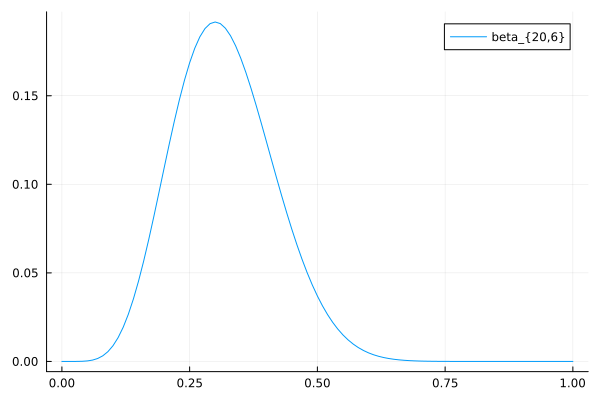

In [4]:
plot(bernstein_beta(20,6),0,1,label="beta_{20,6}")

## Exercise 1

It is your job to implement a function that returns the Bernstein polynomial corresponding to any function f

In [5]:
function bernstein(f::Function, n::Integer)
    p = 0
    for i in 0:n
        p += f(i/n) * bernstein_beta(n,i)
    end
    return p
end    

bernstein (generic function with 1 method)

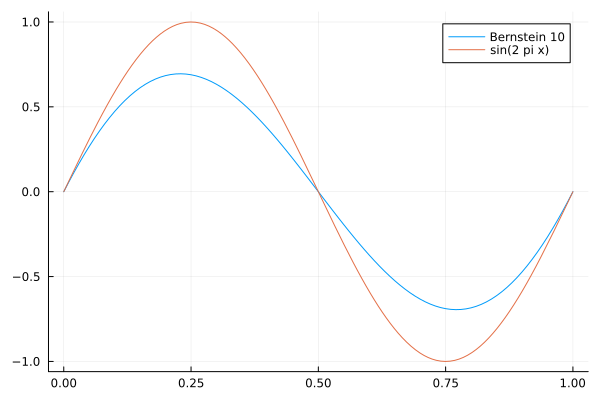

In [6]:
# Let us test if it seems to be working fine
f(t) = sin(2*pi*t)
p = bernstein(f,10)
xg = 0:0.01:1
plot(xg,map(p,xg), label="Bernstein 10")
plot!(f,0,1, label="sin(2 pi x)")

# Lagrange interpolation

You implemented Lagrange interpolation in last week's homework. Here is a possible way to do it.

In [7]:
function newton(f::Function, x::Vector{<:Real})
    n = length(x)
    if (n==1) return f(x[1]) end
    yn = x[1:end-1]
    yl = vcat(x[1:end-2],[x[n]])
    return (newton(f,yn)-newton(f,yl))/(x[n-1]-x[n])
end

function interpolate(f::Function, points::Vector{<:Real})
    n = length(points)  # note that the polynomial will be of degree n-1
    p = Polynomial(0)
    terms = []
    for i in 1:n
        term = Polynomial(newton(f,points[1:i]))
        for j in 1:i-1
            term *= (x-points[j])
        end
        p += term
        push!(terms,term)
    end
    return p
end

interpolate (generic function with 1 method)

## Exercise 2

We now want to generate a sequence of orthogonal polynomials in [0,1] and use them to find the least squares approximation of any given function as a polynomial of degree $\leq n$ in the interval [0,1].

First of all, we need to generate a list of orthogonal polynomials. The following function is supposed to return an array with the orthogonal polynomials $p_0, p_1, p_2, p_3, \dots$ so that each $p_k$ has degree $k$.

In [8]:
function orthogonal_polynomials(n::Integer)
    # This is going to be a list of orthogonal polynomials.
    p = []  
    
    # The first polynomial is just constant 1
    if n>0 push!(p,Polynomial(1)) end 
    for i in 1:n
        q  = x^i
        for j in 0:(i-1)
            q -= integrate(p[j+1]*q,0,1) / integrate(p[j+1]*p[j+1],0,1) * p[j+1]
        end
        push!(p,q)
    end
    return p
end

# The following is a test
orthogonal_polynomials(3)    

4-element Vector{Any}:
 Polynomial(1)
 Polynomial(-0.5 + 1.0*x)
 Polynomial(0.1666666666666669 - 1.0000000000000004*x + 1.0*x^2)
 Polynomial(-0.049999999999999156 + 0.5999999999999941*x - 1.4999999999999938*x^2 + 1.0*x^3)

I provide the function that generates the polynomial of a given degree that best approximates $f$ with respect to the $L^2$ distance. It requires a well done implementation of `orthogonal_polynomials` to work.

Note that we use the function `integrate` to integrate polynomials. It should be fast and roughly exact. We use `quadgk` to integrate numerically any generic function. It is presumably slower and maybe less accurate. We will study how this is done in the next chapter.

In [9]:
function least_squares_approximation(f::Function, degree::Integer)
    ops = orthogonal_polynomials(degree)
    p = Polynomial(0)
    for po in ops
        p += quadgk(t -> f(t)*po(t), 0,1, rtol=1e-14)[1] / integrate(po*po,0,1) * po
    end
    return p
end      
        

least_squares_approximation (generic function with 1 method)

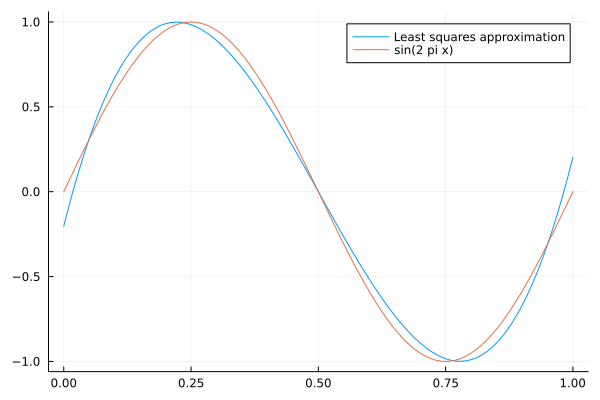

In [10]:
# Let us test if it seems to be working fine
f(t) = sin(2*pi*t)
p = least_squares_approximation(f,4)
xg = 0:0.01:1
plot(xg,map(p,xg), label="Least squares approximation")
plot!(f,0,1, label="sin(2 pi x)")

## Some pictures.

Let us plot a few functions and their corresponding polynomials.

We use a uniform grid in [0,1] for the interpolation. We use polynomials of degree n with (n+1) points.

In [11]:
function plot_all_polynomials(f::Function, n::Integer)
    pB = bernstein(f,n)
    pI = interpolate(f,Array(0:1/n:1))
    pL = least_squares_approximation(f,n)
    xi = 0:0.002:1
    scatter(0:1/n:1, map(f,0:1/n:1), label="Interpolation points")
    plot!(xi,map(f,xi), label="function")
    plot!(xi,map(pB,xi), label="Bernstein polynomial")
    plot!(xi,map(pI,xi), label="Lagrange interpolation")
    plot!(xi,map(pL,xi), label="Least squares approximation")
end

plot_all_polynomials (generic function with 1 method)

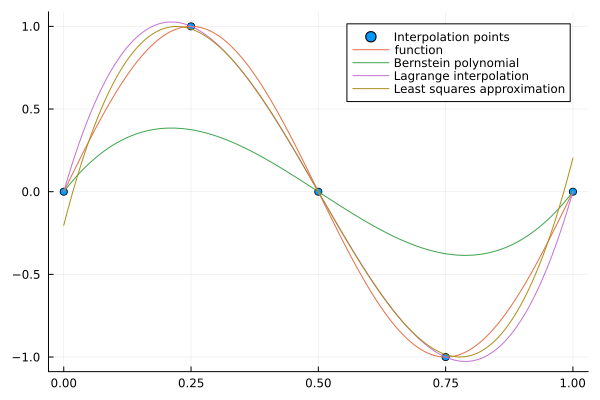

In [12]:
plot_all_polynomials(t->sin(2*pi*t),4)

In this first example, the sine function is very smooth and looks very much like a polinomial. The Lagrange interpolation does a very good job, as well as the least square approximation.

Let us now try a Gaussian, that is very localized near 0.5. We use 9 points.

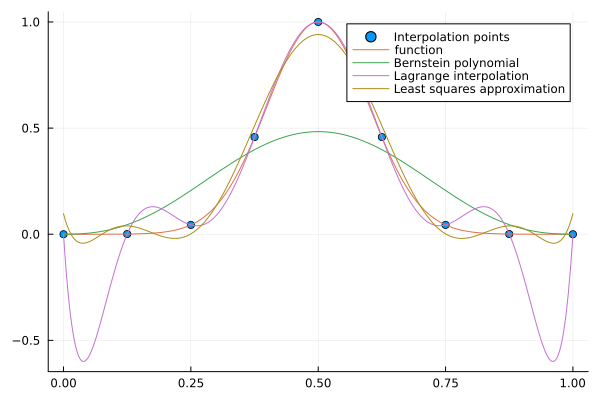

In [13]:
plot_all_polynomials(t->exp(-50*(t-0.5)^2),8)

The Lagrange interpolation polynomial does not look so well any more. The least squares approximation stays somewhere close to the Gaussian. The Bernstein polynomial is still far from the graph, but at least it has more or less the same visual shape.

What if we do it with a few more points?

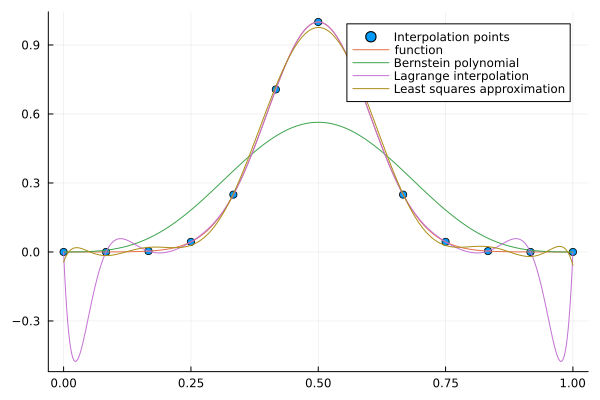

In [14]:
plot_all_polynomials(t->exp(-50*(t-0.5)^2),12)

If I try with more points the least squares approximation seems to lose symmetry. Honestly, I do not understand why. There is no reason for that to happen. I can only think of two reasons:
* The truncation errors in the numerical integration grow out of control.
* I made a mistake in the implementation of the function.
I would appreciate if someone sheds some light on this issue.

Let us now try other functions. Recall that the error in Lagrange interpolation had to do with some higher order derivative of the function. What would happen then, if we apply it to a continuous function that is not differentiable. Let us try a tent function $f(x) = (1 - 4|x-0.5|)_+$.

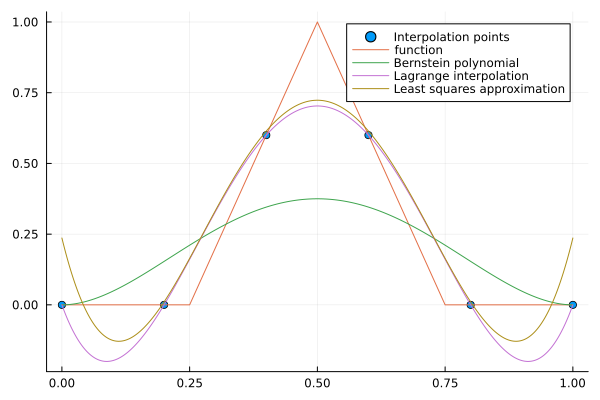

In [15]:
pos(t) = t>0 ? t : 0.

plot_all_polynomials(t->pos(1 - 4*abs(t-0.5)),5)

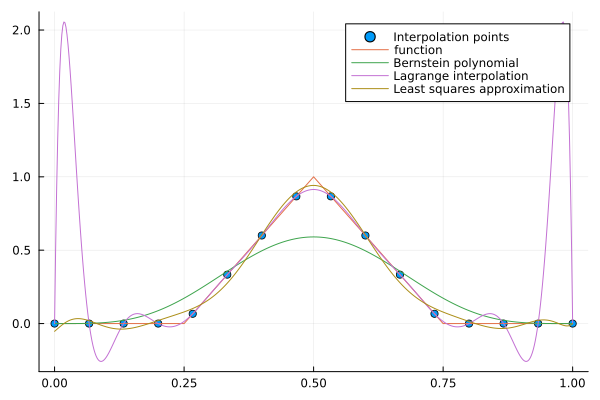

In [16]:
plot_all_polynomials(t->pos(1 - 4*abs(t-0.5)),15)

Noticeably, the Lagrange interpolation has some severe ondulations near the endpoints of the interval.

Let us now try an even more singular function: the heavyside!

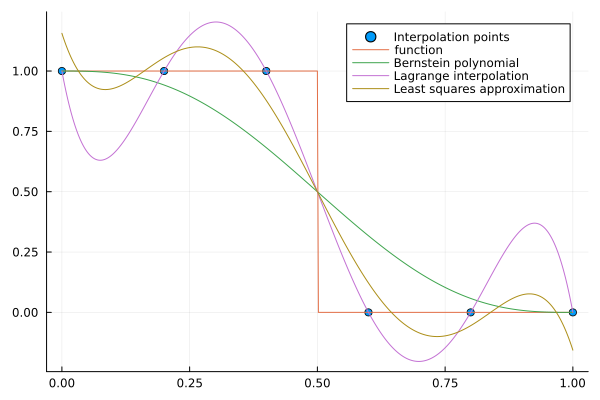

In [17]:
plot_all_polynomials(t-> t>0.5 ? 0. : 1.,5)

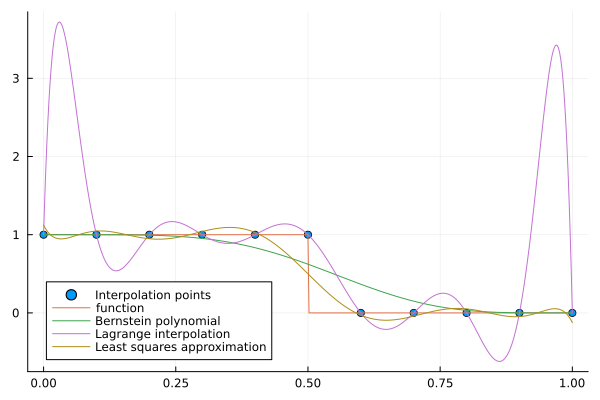

In [18]:
plot_all_polynomials(t-> t>0.5 ? 0. : 1.,10)

## We want a movie!!

In all the pictures above it seems that the Bernstein polynomials do a bad job at approximating the function. However, the Bernstein polynomials always converge to the function as $n \to \infty$. It just takes a large $n$ to get there. Let us see how a sequence of Bernstein polynomials converge to the Gaussian function.

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/2024/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/2024/tmp.gif")
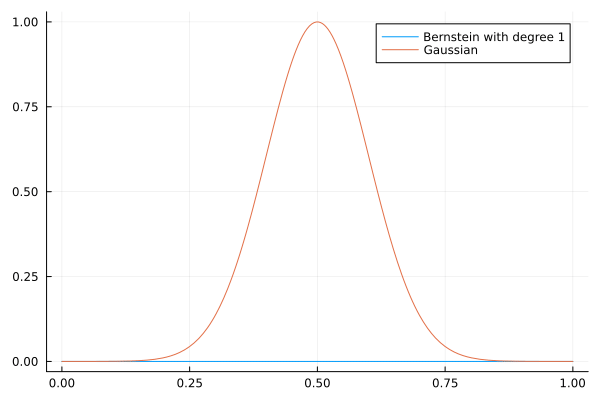

In [19]:
anim = @animate for n in 1:30
    f(t) = exp(-50*(t-0.5)^2)
    pb = bernstein(f,n)
    xg = 0:0.01:1
    yg = map(pb,xg)
    plot(xg,yg, label="Bernstein with degree "*string(n))
    plot!(f,0,1, label="Gaussian")
end
gif(anim,fps=5)

I stopped the computation at degree 30 because I was getting rubbish afterwards. The Bernstein polynomials are supposed to converge to the function as their degree $\to \infty$. But the numerical errors due to floating point truncation eventually become dominant.